# Lab2 - Concrete compressive strength regression
Author: *BHAVYAI GUPTA*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Function definitions

To find the best model, we follow the published article where root-mean squared error (rms) was used as a score function. The rms score function needs to be minimized, because the optimal score is 0, larger values are worse performances. 

In scikit-learn, only *maximization* is implemented. Hence, it is customary to maximize the *negative* rms. scitkit-learn provides a scoring function `neg_root_mean_squared_error`.

In [2]:
from sklearn.model_selection import cross_validate

def get_regressor_neg_rms(model, X, y, cv=7):
    '''Calculate train and validation score for regressor (model) using cross-validation
        
        score is negative root mean-squared error (rms).
        
        model (sklearn classifier): Regressor to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        
        returns: mean training negative rms, mean validation negative rms
    '''
    
    scoring = ['neg_root_mean_squared_error']
    score = cross_validate(estimator=model, X=X, y=y, cv=cv, scoring=scoring, return_train_score=True)

    score_train = score['train_' + scoring[0]].mean()
    score_test = score['test_' + scoring[0]].mean()

    return (score_train, score_test)

## 1. Load data
yellowbrick concrete  
https://www.scikit-yb.org/en/latest/api/datasets/concrete.html

Print the README of the concrete Dataset object. Load the Dataset object by using `return_dataset=True`.


In [3]:
from yellowbrick.datasets.loaders import load_concrete

# loading concrete dataset as a whole
concrete_data = load_concrete(return_dataset=True)

# printing the contents to README
print(concrete_data.README)

# Concrete Compressive Strength

**Downloaded from the UCI Machine Learning Repository on October 13, 2016.**

- Multivariate Data Set
- Real Attributes
- 1,030 Instances
- 9 attributes
- Well suited for _regression_ tasks
- [https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength)

## Abstract

Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients.

## Description

Given are the variable name, variable type, the measurement unit and a brief description. The concrete compressive strength is the regression problem. The order of this listing corresponds to the order of numerals along the rows of the database.

## Attributes

- cement (kg)
- blast furnace slag (kg)
- fly ash (kg)
- water (kg)
- superplasticizer (kg)
- coarse aggregate (kg)
- fine aggregate (kg)
- age (day)
- compressive strength (MPa)

## Citat

### *Question 1:* What is the target variable name and units in this dataset?

As per the information at [here](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength) and in the README, the target variable is `Concrete compressive strength` and its unit is **MPa**. The variable is stored as column **strength**.

### 1.1 Prepare the feature matrix and target vector
Load the concrete data set into feature matrix `X` and target vector `y`.

Print dimensions and type of `X`, `y`.

In [4]:
# loading concrete dataset into feature matrix X and target vector y
X, y = concrete_data.to_data()

print("Type of X       = {}\nDimension of X  = {}\n\nType of y       = {}\nDimension of y  = {}".format(type(X), X.shape, type(y), y.shape))

Type of X       = <class 'pandas.core.frame.DataFrame'>
Dimension of X  = (1030, 8)

Type of y       = <class 'pandas.core.series.Series'>
Dimension of y  = (1030,)


## 2. Inspect the data 

### 2.1 Range of each feature
To get an idea if the features are on the same scale, we inspect the range of features.

Print the minimum and maximum of each feature in `X`.

In [5]:
# printing aggregate (min and max) for the feature matrix
X.aggregate(['min', 'max']).T

,min,max
cement,102.00,540.0
slag,0.00,359.4
ash,0.00,200.1
water,121.75,247.0
splast,0.00,32.2
coarse,801.00,1145.0
fine,594.00,992.6
age,1.00,365.0


### 2.2 Boxplot of features 
Using seaborn boxplot, plot all features. This provides a visual view of feature ranges.

Add y-axis label indicating units, and a title.

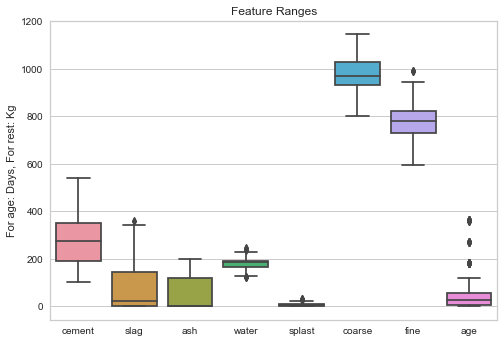

In [6]:
# plot using boxplot
sns.boxplot(data=X);

# add the title
plt.title("Feature Ranges")

# label the y axis
plt.ylabel('For age: Days, For rest: Kg');

### 2.3 Correlation heatmap of features 

To understand if pairs of features are potentially related, contain similar information, pair-wise cross-correlation can be calculated. Models benefit most from un-correlated features.

Using pandas `corr()` method, create the cross-correlations between all features. Plot this cross-correlation object using seaborn `heatmap()` with parameters `vmin=-1, vmax=1, annot=True, cmap='BrBG'`. Add a title.

Pandas `corr()` calculates [Pearson correlation ](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) :
>  It has a value between +1 and −1. A value of +1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

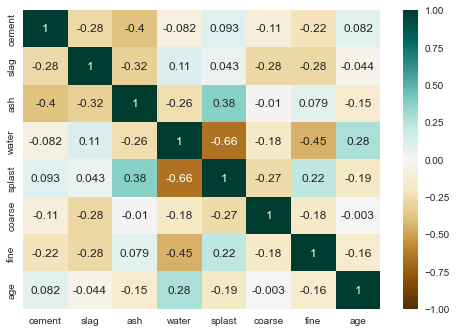

In [8]:
# generate the cross-correlation
X_corr = X.corr()

# plot the heatmap
sns.heatmap(data=X_corr, vmin=-1, vmax=1, annot=True, cmap='BrBG');

### 2.4 Histogram of target variable 

To understand if all target values are equally represented in the data, we analyze how many samples of each target value we have available. The histogram of the target vector can visualize this distribution.

Using seaborn `displot()`, plot the histogram of the target vector. Add a title.

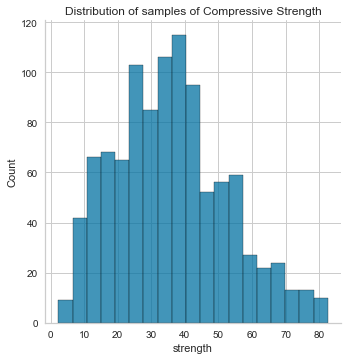

In [10]:
# plot the distribution plot
sns.displot(data=y)

# add the title
plt.title("Distribution of samples of Compressive Strength");

## 3. Create training and test sets

Using scikit-learn `train_test_split()` with parameters `random_state=37`, `test_size=0.2`, split `X` and `y` into training and test sets.

In [11]:
from sklearn.model_selection import train_test_split

# split the data into training set and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=37, test_size=0.2)

## 4. Compare models using cross-validation

Create a list containing a `LinearRegression()`, `RandomForestRegressor(random_state=64)` and `GradientBoostingRegressor(random_state=79)` objects.

Iterate this list, compute the negative root mean-squared error using the `get_regressor_neg_rms()` function, and print the training and validation scores with **2 decimal places**. Use 7-fold cross-validation.

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# create the list of models
model_list = [LinearRegression(), RandomForestRegressor(random_state=64), GradientBoostingRegressor(random_state=79)]

# loop over the model_list to get negative root mean-squared error
for model in model_list:
    print("{} model".format(model.__class__.__name__))

    # calculate the score using all features
    score_train, score_test = get_regressor_neg_rms(model, X_train, y_train, 7)

    # print the scores
    print("  1. Training score = {0:.2f}".format(score_train))
    print("  2. Validation score = {0:.2f}\n".format(score_test))

LinearRegression model
  1. Training score = -10.29
  2. Validation score = -10.39

RandomForestRegressor model
  1. Training score = -2.12
  2. Validation score = -4.97

GradientBoostingRegressor model
  1. Training score = -3.69
  2. Validation score = -4.98



### *Question 2:* For each of the three models, state if models are potentially over- or underfitting and why.

1. LinearRegression
   The model is underfitting. The training and validation scores are similar but very poor. The model has high bias.

2. RandomForestRegressor
   The model is potentially overfitting. The training and validation scores are high, but different. The model has high variance.

3. GradientBoostingRegressor
   The model is potentially overfitting. The training and validation scores are high, but different. The model has high variance.

## 5. Find a better model

Use the `RandomForestRegressor(random_state=64)` and find the best combination of `max_depth` from the list of `[10, 15, 20]`, and `n_estimators` from the list of `[50, 100, 150]`.

Use nested for-loops to iterate these two lists, compute the negative root mean-squared error of the corresponding `RandomForestRegressor(random_state=64)` using the `get_regressor_neg_rms()` function, and print the training and validation scores with **2 decimal places**. Use 7-fold cross-validation.

In [13]:
# variations for max_depth
max_depth_list = [10, 15, 20]

# variations for n_estimators
n_estimators_list = [50, 100, 150]

# print the header
print("+-----------+--------------+-------------+------------+")
print("| max_depth | n_estimators | train_score | test_score |")
print("+-----------+--------------+-------------+------------+")

# loop over max_depth_list and n_estimators_list
for md in max_depth_list:
    for ne in n_estimators_list:
        # instantiate the model with selected hyper-parameters
        rfr_model = RandomForestRegressor(n_estimators=ne, max_depth=md, random_state=64)
        
        # get the scores on the instantiated model
        score_train, score_test = get_regressor_neg_rms(rfr_model, X_train, y_train, 7)

        # print the hyperparameters used and corresponding scores
        print("| {:>9} | {:>12} | {:11.2f} | {:10.2f} |".format(md, ne, score_train, score_test))

print("+-----------+--------------+-------------+------------+")

+-----------+--------------+-------------+------------+
| max_depth | n_estimators | train_score | test_score |
+-----------+--------------+-------------+------------+
|        10 |           50 |       -2.48 |      -5.14 |
|        10 |          100 |       -2.44 |      -5.09 |
|        10 |          150 |       -2.42 |      -5.06 |
|        15 |           50 |       -2.17 |      -5.02 |
|        15 |          100 |       -2.12 |      -4.97 |
|        15 |          150 |       -2.10 |      -4.94 |
|        20 |           50 |       -2.16 |      -5.02 |
|        20 |          100 |       -2.12 |      -4.97 |
|        20 |          150 |       -2.10 |      -4.93 |
+-----------+--------------+-------------+------------+


### *Question 3:* Which combination of `max_depth` and `n_estimators` produced the best validation score? Report this score here.

The best scores were reported by the model and below vaule of hyperparameters were used.

`max_depth` = 20  
`n_estimators` = 150

## 6. Retrain best model

Create a `RandomForestRegressor(random_state=64)` with the best pair of `max_depth` and `n_estimators`, and retrain this model on all training data.

In [14]:
# create the model with best pair of hyper-parameters
model = RandomForestRegressor(n_estimators=150, max_depth=20, random_state=64)

# fit the model on all training data
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=150, random_state=64)

## 7. Evaluate best model on training and test data
### 7.1 Root mean-squared error and R-squared

For the retrained best estimator, print the root mean-squared error (**2 decimal places**) and R-squared (**3 decimal places**) for training and test sets.

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# predict the data on training set
y_train_predicted = model.predict(X_train)

# get the training rms
rms_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))

# get the training r2
r2_train = r2_score(y_train, y_train_predicted)

# predict the data on validation set
y_test_predicted = model.predict(X_test)

# get the validation rms
rms_test = np.sqrt(mean_squared_error(y_test, y_test_predicted))

# get the test r2
r2_test = r2_score(y_test, y_test_predicted)

print("Training   RMS = {:.2f} MPa (R2 = {:.3f})".format(rms_train, r2_train))
print("Validation RMS = {:.2f} MPa (R2 = {:.3f})".format(rms_test, r2_test))

Training   RMS = 2.00 MPa (R2 = 0.986)
Validation RMS = 4.87 MPa (R2 = 0.913)


### *Question 4:* How does this test score compare to the polynomial regression and neural network reported in the article? Do we outperform the reported models?

+ Our model outperforms polynomial regression. Our RMS is lower and R2 is more closer to 1 as compared to neural network.

+ Our model falls behind neural network. Our RMS is higher and R2 is farther from 1 as compared to neural network.

### 7.2 Predicted vs actual strength plot
Using a scatterplot, show predicted strength on the x axis and actual strength on the y axis with data from the test set. With this plot, we can see where we make errors.

Add a line of unity (diagonal with slope 1 and offset 0). Ideally, all points would be on this line. We look for points being distributed equally around the line of unity.

Add x-axis, y-axis labels including units, and a title.


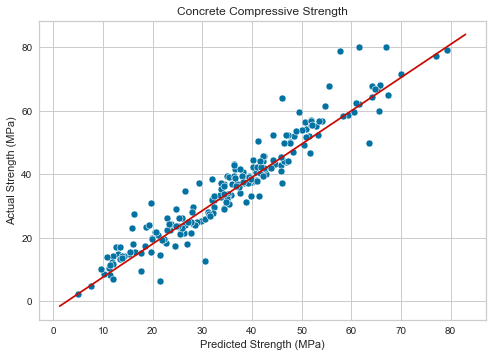

In [16]:
sns.scatterplot(x=y_test_predicted, y=y_test)

# adding line of unity
plt.plot(plt.xlim(), plt.ylim(), color='r')

# add the title
plt.title("Concrete Compressive Strength")

# label the axes
plt.xlabel('Predicted Strength (MPa)');
plt.ylabel('Actual Strength (MPa)');

### 7.3 Residual plot
Using a scatterplot, show predicted strength on the x axis and the *difference* between actual and predicted strength on the y axis with data from the test set. This is an alternative way to see where errors are made.

We look for residuals being distributed equally around the zero horizontal line.

Add x-axis, y-axis labels including units, and a title.



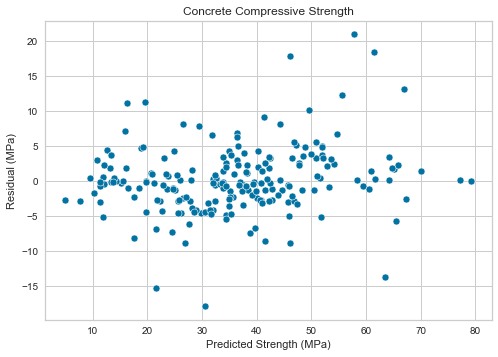

In [17]:
sns.scatterplot(x=y_test_predicted, y=y_test-y_test_predicted)

# add the title
plt.title("Concrete Compressive Strength")

# label the axes
plt.xlabel('Predicted Strength (MPa)');
plt.ylabel('Residual (MPa)');

## 8. Conclusion

In conclusion, comment on the following items:
- Did we find a model that outperformes the polynomial regression reported in the reference article? Explain.
- Did we find a model that outperformes the neural network reported in the reference article? Explain.
- What was the assumption about the dataset and the reference article? How does this affect your conclusions?


*YOUR ANSWER HERE*


## 9. Reflection



Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating while working on this assignment.

*ADD YOUR THOUGHTS HERE*

# Appendix: Optional - use grid search to find the best model parameters.

## Workflow overview

In [ ]:
import mglearn
mglearn.plots.plot_grid_search_overview()

## A-1. Hyperparameter tuning using grid search 

The inital cross-validation above showed that both DecisionTree based models might have merit. Next, the hyperparameters are tuned using grid search.

### A-1.1 Grid search for RandomForestRegressor

Perform grid search using `GridSearchCV` for the `RandomForestRegressor(random_state=64)`.

Grid search to use 7-fold cross-validation, and `neg_root_mean_squared_error` as the scoring function.

Use the following hyperparameters and values:
- `'n_estimators': [100, 200, 500]`
- `'max_depth': [ 11, 13, 15, 17]`
- `'max_features': ['auto', 'log2', None]`


In [ ]:
# TODO: Setup grid search for RandomForestRegressor(random_state=64)


In [ ]:
# TODO: perform the grid search by calling fit()


In [ ]:
# TODO: Print the best parameters


In [ ]:
# TODO: Print the best score


### A-5.2 Grid search for gradient boosted tree

Perform grid search using `GridSearchCV` for the `GradientBoostingRegressor(random_state=79)`.

Grid search to use 7-fold cross-validation, and `neg_root_mean_squared_error` as the scoring function.

Use the following hyperparameters and values:
- `'n_estimators': [100, 200, 500]`
- `'max_depth': [1, 3, 5, 7]`
- `'learning_rate': [0.01, 0.1, 1.0]`

In [ ]:
# TODO: Setup grid search for GradientBoostingRegressor(random_state=79)


In [ ]:
# TODO: perform the grid search by calling fit()


In [ ]:
# TODO: Print the best parameters


In [ ]:
# TODO: Print the best score


### *Question A-1:* Which of the two models produces the best score? What is the best score?

*YOUR ANSWER HERE*


## A-2. Retrain best model

Get the best estimator from the two grid searches above and retrain this model on all training data.

In [ ]:
#TODO: retrain the best estimator



## A-3. Model evaluation and conclusion

Repeat steps in Section 7 above for the best model.

Revisit your conclusion.